# Libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np 

# Canny edge detection function 

In [2]:
def canny (image) :
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY); # gray scale 
    hls = cv2.cvtColor(test_image , cv2.COLOR_RGB2HLS)
    s = hls [:,:,2]
    filter_size = 5 ;
    blur = cv2.GaussianBlur(s,(filter_size,filter_size),0);
    canny = cv2.Canny(blur,50,150); # 50 & 150 are the threshold values 
    return canny
    

# Perspective Transfrom

In [3]:
def binary(img):
    detected_image = canny(img) ; #output of canny detection 
    # Vertices extracted manually for performing a perspective transform
    bottom_left = [220,715]
    bottom_right = [1110, 715]
    top_left = [570, 470]
    top_right = [722, 470]

    source = np.float32([bottom_left,bottom_right,top_right,top_left])

    # Draw lines in image by these points by red color and its closed shape 
    pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
    #print(pts,pts.shape)
    pts = pts.reshape((4,1,2)) # to make each point as a list
    #print(pts,pts.shape)
    copy = img.copy()
    is_closed = True        
    cv2.polylines(copy,[pts],is_closed,(255,0,0), thickness=3) 
   
    
    # Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
    bottom_left = [320,720]
    bottom_right = [920, 720]
    top_left = [320, 1]
    top_right = [920, 1]

    dst = np.float32([bottom_left,bottom_right,top_right,top_left])
    M = cv2.getPerspectiveTransform(source, dst) 
    # M is the matrix of perspective which mutliply with original and get the wrapped image
    M_inv = cv2.getPerspectiveTransform(dst, source)
    print(img.shape)
    img_size = (img.shape[1], img.shape[0]) 
    warped = cv2.warpPerspective(detected_image, M, img_size , flags=cv2.INTER_LINEAR)
    return warped, M_inv,copy

# Test_Image 

(720, 1280, 3)


Text(0.5, 1.0, 'Warped Image')

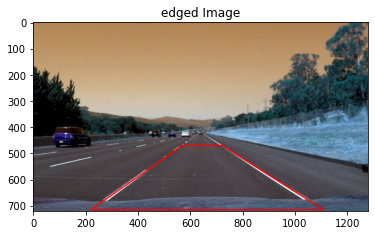

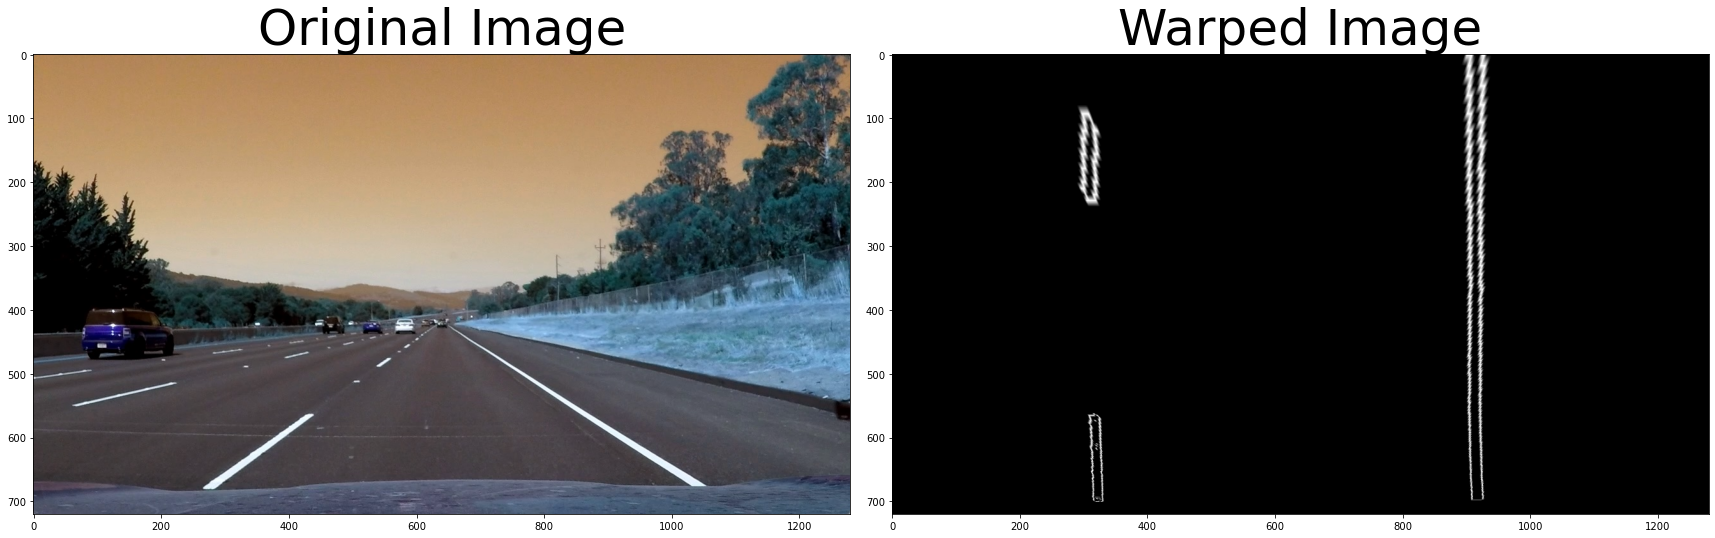

In [4]:
test_image = cv2.imread('./test_images/straight_lines2.jpg')
warped, M_inv,edged_one = binary(test_image)
plt.imshow(edged_one, cmap='gray')
plt.title('edged Image')

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)

# Vedio

In [ ]:
#import numpy as np
#import cv2
#from google.colab.patches import cv2_imshow #if not using colab delete this line
cap = cv2.VideoCapture('project_video.mp4') #enter the url of the video
while(cap.isOpened()):
  ret, frame = cap.read() #the frame is like the image
  print(ret)
  if ret == True:
    warped, M_inv,edged_one = binary(frame)
    # Display the resulting frame19
    cv2.imshow('Frame',edged_one)
  ###################code edge detection ################################
  #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 

########################end of code##############################
  #cv2_imshow(gray) # if not using collab make the function : cv2.imshaow("title",gray)
  if cv2.waitKey(1) & 0xFF == ord('q'):
    break

cap.release()
cv2.destroyAllWindows()


True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)


True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)


(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True


True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
True
(720, 1280, 3)
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals